In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

In [180]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
%pip install kaggle --quiet

In [ ]:
%pip install torchtext==0.6.0

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = '/content/drive/MyDrive/kaggle.json'

!mkdir ~/.kaggle
!cp {path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions

100% 1.04G/1.04G [00:45<00:00, 22.5MB/s]
100% 1.04G/1.04G [00:45<00:00, 24.6MB/s]


In [9]:
import zipfile
zip_file = "flickr8kimagescaptions.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')
print('Unzipped the dataset.')
#drive.flush_and_unmount()
#print('Google Drive unmounted.')


Unzipped the dataset.


In [10]:
caption_file_path = '/content/dataset/flickr8k/captions.txt'

with open(caption_file_path, 'r') as file:
    lines = file.readlines()

data = []

for line in lines:
    image_name, caption = line.split(',', 1)
    data.append({'image': image_name.strip(), 'caption': caption.strip()})

df = pd.DataFrame(data)
df = df.drop(0).reset_index(drop=True)

In [11]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [12]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [13]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x: len(x))
max_seq_len = df['seq_len'].max()

In [14]:
df.drop(['seq_len'], axis=1, inplace=True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

create vocab and mapping of token to ID

In [15]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [16]:
print(len(word_dict))
print(word_dict[:5])

8352
['<pad>', '<start>', '<end>', 'in', 'the']


In [16]:
vocab_size = len(word_dict)
print(vocab_size)

8352


In [17]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8352 8352


In [18]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [19]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [21]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


In [22]:
len(train)/len(df)*100

89.9987640588308

In [20]:
train_samples = len(train)
print(train_samples)

36409


In [21]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

7282 810


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
from torchvision import models

class extract_densenet(Dataset):
    def __init__(self, data):
        self.data = data
        self.scalar = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = '/content/dataset/flickr8k/images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scalar(img))).to(device)

        return image_name, t_img

In [24]:
train_dataset_densenet = extract_densenet(unq_train_imgs)
train_dataloader_densenet = DataLoader(train_dataset_densenet, batch_size = 1, shuffle=False)

In [25]:
valid_dataset_densenet = extract_densenet(unq_valid_imgs)
valid_dataloader_densenet = DataLoader(valid_dataset_densenet, batch_size = 1, shuffle=False)

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
densenet = torchvision.models.densenet121(pretrained=True).to(device)
res_list = list(resnet._modules)
den_list = list(densenet._modules)
print(f'resnet: {res_list}')
print(f'densenet: {den_list}')

In [ ]:
densenet.eval()
den_layer = densenet._modules.get('features').to(device)

In [26]:
def get_vector(t_img):

    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 1024, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = den_layer.register_forward_hook(copy_data)
    densenet(t_img)

    h.remove()
    return my_embedding

In [ ]:
extracted_tr = {}
for image_name, t_img in tqdm(train_dataloader_densenet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extracted_tr[image_name[0]] = embdg

  0%|          | 0/7282 [00:00<?, ?it/s]

In [ ]:
a_file = open('/content/drive/MyDrive/dl_project/densenet/EncodedImageTrainDensenet.pkl', 'wb')
pickle.dump(extracted_tr, a_file)
a_file.close()

In [ ]:
extracted_val = {}
for image_name, t_img in tqdm(valid_dataloader_densenet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extracted_val[image_name[0]] = embdg

  0%|          | 0/810 [00:00<?, ?it/s]

In [ ]:
a_file = open('/content/drive/MyDrive/dl_project/densenet/EncodedImageValidDensenet.pkl', 'wb')
pickle.dump(extracted_val, a_file)
a_file.close()

In [27]:
class FlickerDataSetDensenet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [28]:
train_dataset_resnet = FlickerDataSetDensenet(train, '/content/drive/MyDrive/dl_project/densenet/EncodedImageTrainDensenet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [29]:
valid_dataset_resnet = FlickerDataSetDensenet(valid, '/content/drive/MyDrive/dl_project/densenet/EncodedImageValidDensenet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

position embedding

In [30]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]

        x = x + self.pe
        return self.dropout(x)

Transformer Decoder

In [31]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0, 1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model = embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(
                                                            decoder_input_mask == 0, float('-inf')
                                                            ).masked_fill(
                                                                decoder_input_mask == 1, float(0.0))
        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)


        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask



train

In [ ]:
EPOCH = 30

In [ ]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 1024).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float('Inf')

<ipython-input-44-b2565ed41eae>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_val_loss = np.float('Inf')


In [ ]:
df.columns

Index(['image', 'caption', 'cleaned_caption', 'text_seq'], dtype='object')

In [ ]:
train_loss = []
val_loss = []

In [ ]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        #print(image_embed.shape, caption_seq.shape)
        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)


    total_epoch_train_loss = total_epoch_train_loss/total_train_words


    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words

    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )

    train_loss.append(total_epoch_train_loss.item())
    val_loss.append(total_epoch_valid_loss.item())


    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, '/content/drive/MyDrive/dl_project/densenet/BestModel')
        min_val_loss = total_epoch_valid_loss


    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  4.887479305267334 Eval Loss ->  4.059604644775391
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  3.8523452281951904 Eval Loss ->  3.705972671508789
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.509573221206665 Eval Loss ->  3.544264316558838
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.2753243446350098 Eval Loss ->  3.4434316158294678
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.091362714767456 Eval Loss ->  3.3824284076690674
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  2.934764862060547 Eval Loss ->  3.3424973487854004
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  2.796109676361084 Eval Loss ->  3.317267656326294
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  2.6707208156585693 Eval Loss ->  3.3059730529785156
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  2.5527920722961426 Eval Loss ->  3.303034543991089
Writing Model at epoch  8
Epoch ->  9  Training Loss ->

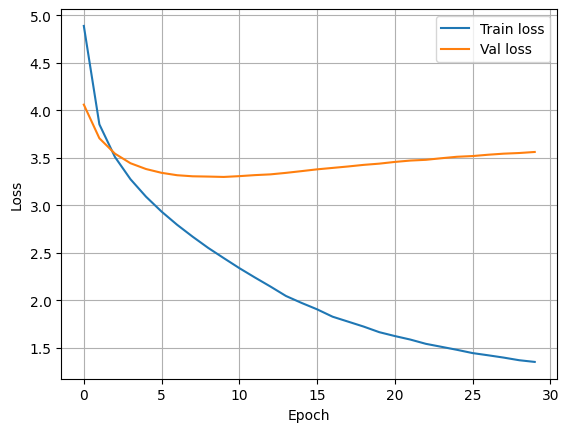

In [ ]:
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [32]:
model = torch.load('/content/drive/MyDrive/dl_project/densenet/BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 32
print(start_token, end_token, pad_token)

1 2 0


In [33]:
valid_img_embed = pd.read_pickle('/content/drive/MyDrive/dl_project/densenet/EncodedImageValidDensenet.pkl')

In [162]:
def generate_caption(K, img_nm):
    img_loc = '/content/dataset/flickr8k/images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.axis('off')
    plt.imshow(image)

    model.eval()
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            current_seed = seed + eval_iter * K  # 각 k값에 따라 다른 시드 계산
            random.seed(current_seed)
            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
two little boys play on playground .


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


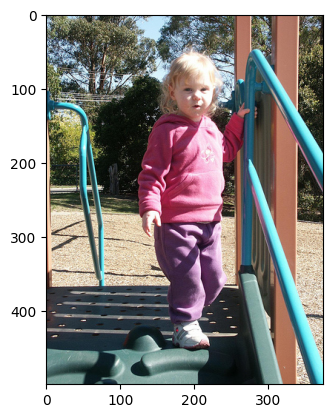

In [ ]:
generate_caption(1, unq_valid_imgs.iloc[50]['image'])

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
two little girls are playing on the playground equipment on the playground equipment and slide at the playground .


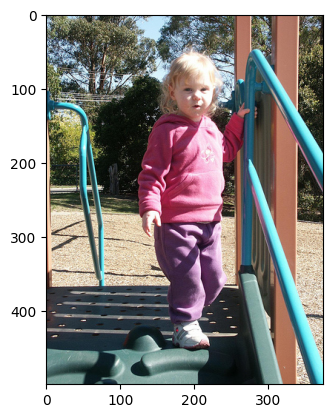

In [ ]:
generate_caption(2, unq_valid_imgs.iloc[50]['image'])

Actual Caption : 
['"Two black , brown and white dogs running in green grass with ears up on heads ."', 'Two dogs run through a field of grass', 'Two fluffy dogs run through the grass .', 'Two look-alike dogs running in the green grass .', 'Two small dogs run through the grass .']


Predicted caption : 
three black dogs are running through the green field with green toy in its mouth .


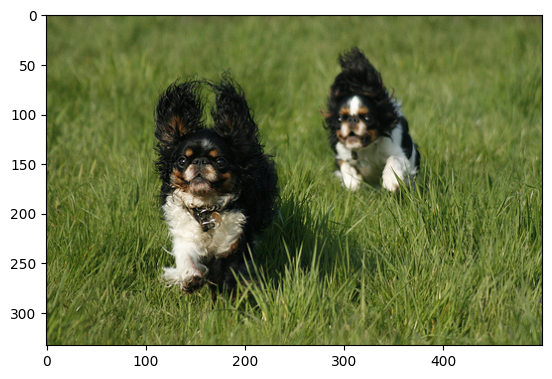

In [ ]:
generate_caption(2, unq_valid_imgs.iloc[70]['image'])

Actual Caption : 
['A distant person is climbing up a very sheer mountain .', 'A panoramic distance view of a rock climber going up a steep mountain wall .', 'person rock climbing', 'There is a person scaling a very steep rock wall .', 'This person is climbing the side of a mountain .']


Predicted caption : 
person climbing up rock .


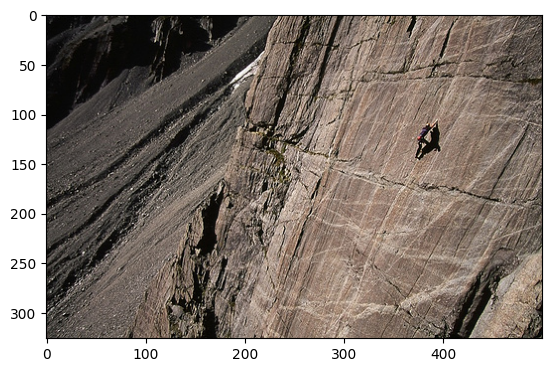

In [ ]:
generate_caption(2, unq_valid_imgs.iloc[100]['image'])

In [2]:
%pip install rouge

In [35]:
test_captions = {}
for idx, row in valid.iterrows():
    image_id = row['image']
    caption = row['caption']

    if image_id not in test_captions:
        test_captions[image_id] = []
    test_captions[image_id].append(caption)

In [36]:
# bleu
# Most common text evaliuation methods
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge

In [37]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [156]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from nltk.translate.bleu_score import SmoothingFunction

seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

def calculate_bleu(references, candidate):
    smoothing = SmoothingFunction().method1
    bleu_score = sentence_bleu(references, candidate, smoothing_function=smoothing)

    return bleu_score

def calculate_rouge(references, candidate):
    rouge = Rouge()

    candidate = " ".join([candidate])
    rouge = Rouge()
    scores = []
    for ref in references:
        r_scores = rouge.get_scores(candidate, ref)
        scores.append(r_scores[0]['rouge-1']['f'])

    return max(scores)

def calculate_meteor(references, candidate):

    references_tokenized = [word_tokenize(ref) for ref in references]
    scores = []
    for i in range(len(references_tokenized)):
        scores.append(meteor_score([references_tokenized[i]], word_tokenize(candidate)))

    return max(scores)


In [167]:
def scores(target):

    img_col = []
    k_col = []
    bleu_col = []
    rouge_col = []
    meteor_col = []

    for idx, row in tqdm(target.iterrows(), total=len(target)):

        for K in range(1, 6):
            model.eval()
            img_nm = row['image']

            valid_img_df = valid[valid['image']==img_nm]

            img_embed = valid_img_embed[img_nm].to(device)


            img_embed = img_embed.permute(0,2,3,1)
            img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


            input_seq = [pad_token]*max_seq_len*2
            #print(f'input_seq = {input_seq}')
            input_seq[0] = start_token       # <start> <pad> <pad> ...

            input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
            predicted_sentence = []
            with torch.no_grad():
                for eval_iter in range(0, max_seq_len): # max_seq_len: 생성하는 시퀀스 최대 길이

                    # 순방향 전파
                    # model.forward(이미지 추출 특성, 현재까지 생성한 시퀀스)
                    output, padding_mask = model.forward(img_embed, input_seq)

                    output = output[eval_iter, 0, :]  # 다음 예측값

                    values = torch.topk(output, K).values.tolist()  # 상위 K개 확률값
                    indices = torch.topk(output, K).indices.tolist()  # 상위 K개 확률값에 해당하는 인덱스 (모델 어휘 사전에서 각 단어)

                    current_seed = seed + eval_iter * K  # 각 k값에 따라 다른 시드 계산
                    random.seed(current_seed)
                    next_word_index = random.choices(indices, values, k = 1)[0]

                    next_word = index_to_word[next_word_index]

                    input_seq[:, eval_iter+1] = next_word_index

                    if next_word == '<end>' :
                        break

                    predicted_sentence.append(next_word)

            # 생성된 캡션
            generated_caption = " ".join(predicted_sentence + ['.'])

            # BLEU 스코어 계산을 위해 실제 캡션 가져오기
            actual_captions = valid_img_df['caption'].tolist()
            #print(K, actual_captions)
            #print(generated_caption)
            #print()

            bleu_score = calculate_bleu(actual_captions, generated_caption)
            rouge_score = calculate_rouge(actual_captions, generated_caption)
            meteor_score = calculate_meteor(actual_captions, generated_caption)

            img_col.append(img_nm)
            k_col.append(K)
            bleu_col.append(bleu_score)
            rouge_col.append(rouge_score)
            meteor_col.append(meteor_score)


    df = pd.DataFrame({
        'image': img_col,
        'K': k_col,
        'bleu': bleu_col,
        'rouge': rouge_col,
        'meteor': meteor_col
    })

    return df


In [168]:
%%time
df2 = scores(unq_valid_imgs)

  0%|          | 0/810 [00:00<?, ?it/s]

CPU times: user 20min 34s, sys: 1.06 s, total: 20min 35s
Wall time: 5min 10s


점수 낮은 캡션 확인

In [169]:
df2.sort_values(by='bleu', ascending=False)

,image,K,bleu,rouge,meteor
3570,878758390_dd2cdc42f6.jpg,1,1.000000,0.800000,0.897999
2830,69710411_2cf537f61f.jpg,1,0.982082,0.777778,0.684267
2405,57417274_d55d34e93e.jpg,1,0.980188,0.571429,0.736111
3435,848293676_98e73c52c1.jpg,1,0.979650,0.700000,0.665732
355,457945610_1a23b9ced0.jpg,1,0.976454,0.500000,0.436047
...,...,...,...,...,...
604,470887791_86d5a08a38.jpg,5,0.056494,0.125000,0.132412
3661,909808296_23c427022d.jpg,2,0.053112,0.142857,0.115385
1577,516725192_c9cdd63878.jpg,3,0.041361,0.142857,0.098039
968,488408004_a1e26d4886.jpg,4,0.030249,0.095238,0.054054


Actual Caption : 
['A fisherman stands on the beach on a gray day .', 'A man holding a fishing pole and tackle box walking in from the ocean .', 'a man in a yellow cap is on the beach carrying a fishing pole .', 'A Man with a fishing pole standing on a beach .', 'A person is standing in the ocean fully clothed holding a fishing pole in one hand and a tackle box in the other .']


Predicted caption : 
man surfing .


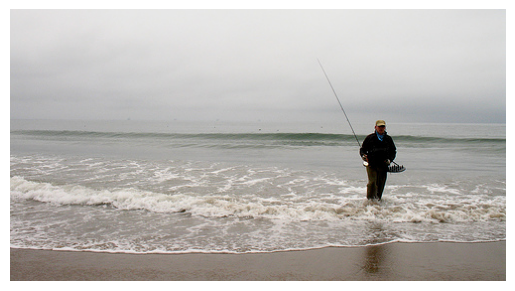

In [231]:
generate_caption(3, '516725192_c9cdd63878.jpg')

Actual Caption : 
['A child in formal clothing is walking along the edge of a stony area that is littered in places .', 'A little boy with a blue jacket is making a sour face at the camera .', 'A young boy wearing a light blue jacket walks across the brick patio .', 'A young boy with a blue coat makes a funny face as he walks towards the grass .', '"The young boy is walking wearing a blue jacket , a black sweater and white collared shirt ."']


Predicted caption : 
two women in tuxedos .


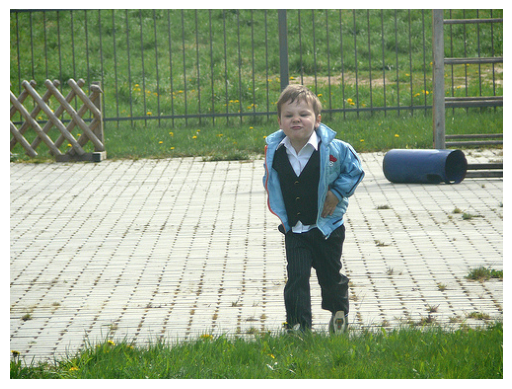

In [182]:
generate_caption(4, '488408004_a1e26d4886.jpg')

Actual Caption : 
["A man holding up a red sign that offers the honest trade of a good poem for a Giant 's ticket .", 'A man holds a sign offering to trade a poem for a football ticket .', 'A man holds a sign offering to trade a poem for a Giants ticket .', 'A man in a grey shirt and backpack is offering poems for a Giants ticket .', 'Desperate Giant fan tries a creative approach to garner tickets .']


Predicted caption : 
two people walk down city road .


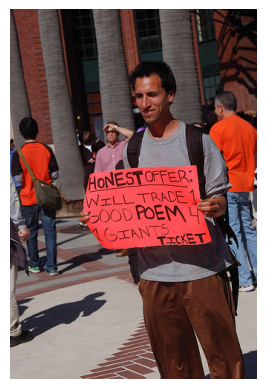

In [181]:
generate_caption(5, '523327429_af093fc7cf.jpg')

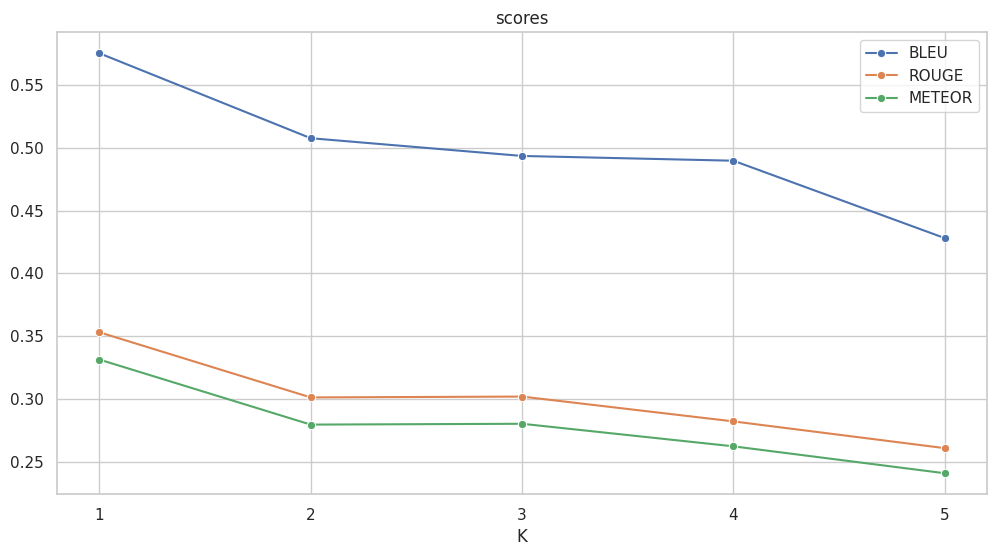

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 그리기
sns.set(style="whitegrid")

# Bleu 그래프
plt.figure(figsize=(12, 6))
sns.lineplot(x='K', y='bleu', data=df2, marker='o', label='BLEU', errorbar=None)

# Rouge 그래프
#plt.figure(figsize=(12, 6))
sns.lineplot(x='K', y='rouge', data=df2, marker='o', label='ROUGE',  errorbar=None)

# Meteor 그래프
#plt.figure(figsize=(12, 6))
sns.lineplot(x='K', y='meteor', data=df2, marker='o', label='METEOR', errorbar=None)

plt.ylabel("")
plt.xticks(df2['K'].unique())
plt.title('scores')
plt.show()

각 이미지별로 5개의 K값 중 가장 점수 잘 나오는 캡션 선택
1. bleu, rouge, meteor의 평균점수
2. bleu, rouge, meteor중 가장 높은 점수

In [230]:
df3 = df2.copy()
df3['mean_score'] = (df3['bleu'] + df2['rouge'] + df3['meteor']) / 3
df3['max'] = df3[['bleu', 'rouge', 'meteor']].max(axis=1)

In [212]:
from tqdm import tqdm

high_idx = []
old_id = None
max_score = None
max_idx = None
idxx = []

for idx, row in tqdm(df3.iterrows(), total=len(df3)):
    if row['image'] != old_id:
        if max_idx is not None:
            high_idx.append(max_idx)
        old_id = row['image']
        max_score = row['mean_score']
        max_idx = idx
    elif row['mean_score'] > max_score:
        max_score = row['mean_score']
        max_idx = idx

# 마지막 이미지의 최대 인덱스 추가
if max_idx is not None:
    high_idx.append(max_idx)

# idxx 리스트에 최대 인덱스들 추가
idxx.extend(high_idx)


100%|██████████| 4050/4050 [00:00<00:00, 23642.61it/s]


In [213]:
df_high_mean = df3.loc[idxx]

K값이 1인 것이 평균점수 가장 높은 경우가 많음.

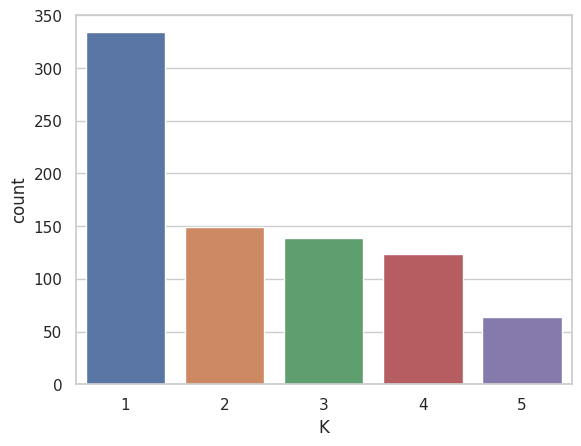

In [214]:
sns.countplot(data=df_high_mean, x='K');

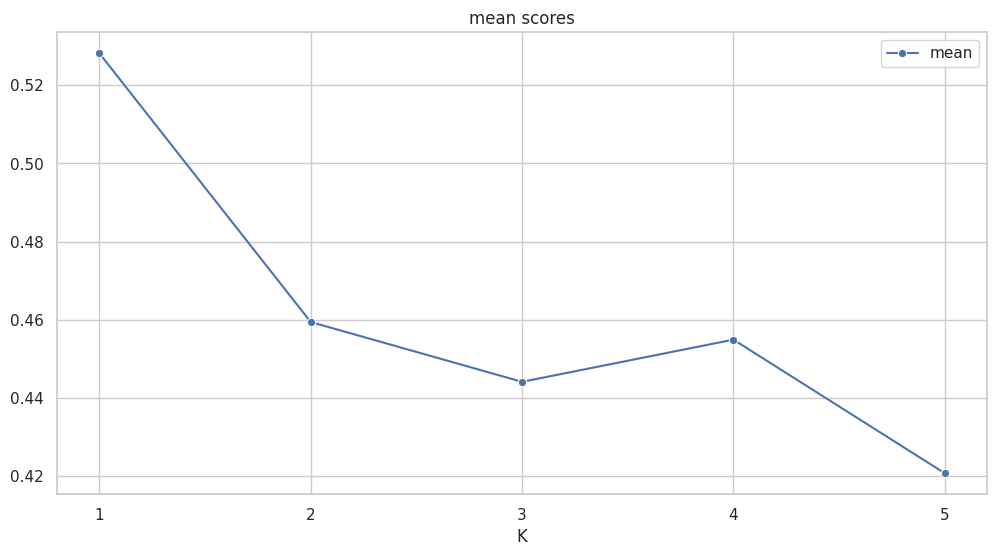

In [224]:
# 그래프 그리기
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(x='K', y='mean_score', data=df_high_mean, marker='o', label='mean', errorbar=None)


plt.ylabel("")
plt.xticks(df_high_mean['K'].unique())
plt.title('mean scores')
plt.show()

셋 중 가장 높은 점수 선택시

In [216]:
from tqdm import tqdm

high_idx = []
old_id = None
max_score = None
max_idx = None
idxx = []

for idx, row in tqdm(df3.iterrows(), total=len(df3)):
    if row['image'] != old_id:
        if max_idx is not None:
            high_idx.append(max_idx)
        old_id = row['image']
        max_score = row['max']
        max_idx = idx
    elif row['max'] > max_score:
        max_score = row['max']
        max_idx = idx

# 마지막 이미지의 최대 인덱스 추가
if max_idx is not None:
    high_idx.append(max_idx)

# idxx 리스트에 최대 인덱스들 추가
idxx.extend(high_idx)


100%|██████████| 4050/4050 [00:00<00:00, 23744.89it/s]


In [218]:
df_high_max = df3.loc[idxx]

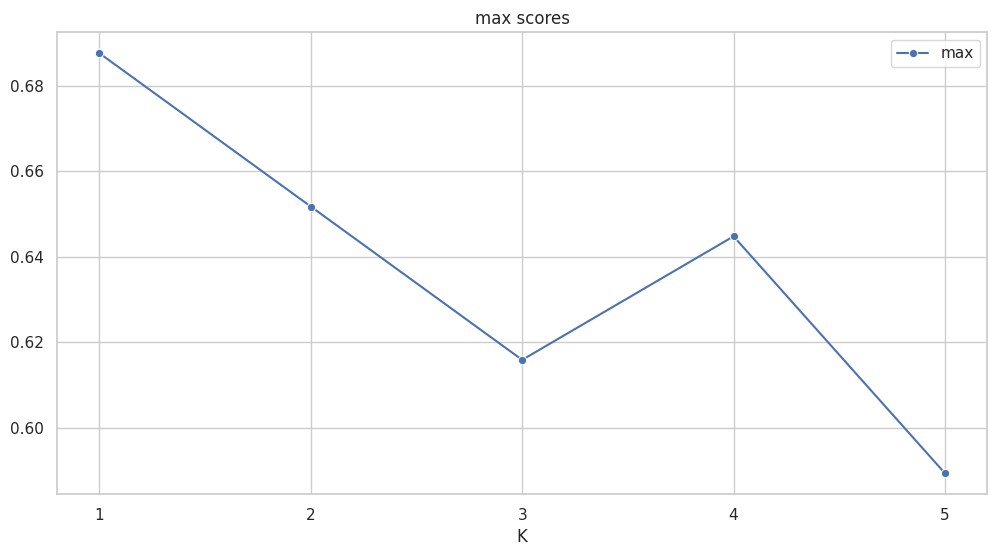

In [225]:
# 그래프 그리기
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(x='K', y='max', data=df_high_max, marker='o', label='max', errorbar=None)

plt.ylabel("")
plt.xticks(df_high_max['K'].unique())
plt.title('max scores')
plt.show()

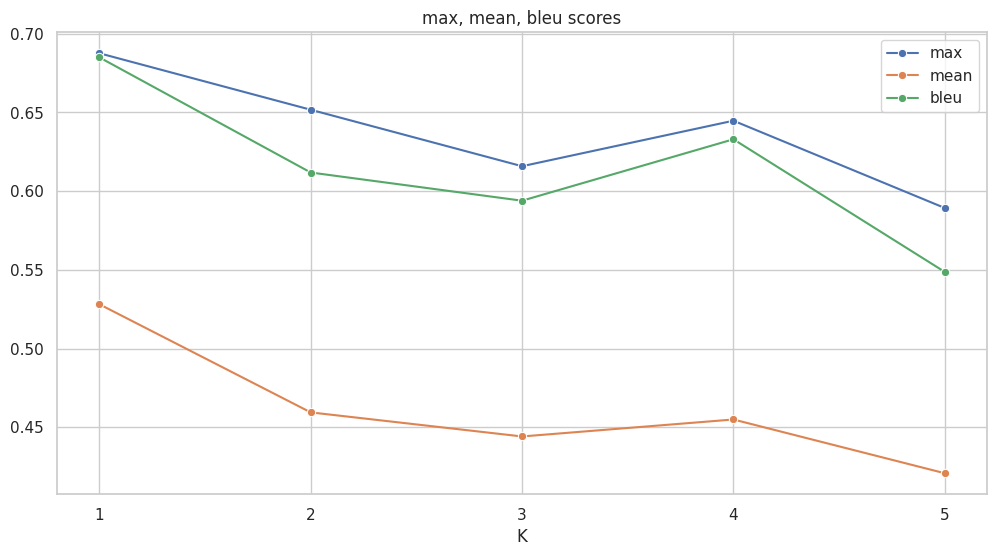

In [229]:
# 그래프 그리기
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(x='K', y='max', data=df_high_max, marker='o', label='max', errorbar=None)
sns.lineplot(x='K', y='mean_score', data=df_high_mean, marker='o', label='mean', errorbar=None)
sns.lineplot(x='K', y='bleu', data=df_high_mean, marker='o', label='bleu', errorbar=None) # bleu score가 전체적으로 가장 높아보여서 추가

plt.ylabel("")
plt.xticks(df_high_max['K'].unique())
plt.title('max, mean, bleu scores')
plt.show()